# Mask R-CNN - Train on Camus Dataset

This notebook shows how to train Mask R-CNN on CAMUS dataset

In [1]:
import os
import sys
import datetime
import numpy as np
import skimage.draw
import SimpleITK as sitk
import matplotlib.pylab as plt
from imgaug import augmenters as iaa



# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn import visualize
from mrcnn.visualize import display_images

# Path to trained weights file
# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

class CamusConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "Camus"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    GPU_COUNT = 1
    
#     IMAGE_MIN_DIM = 512
#     IMAGE_MAX_DIM = 512
#     IMAGES_PER_GPU = 4
    IMAGE_MIN_DIM=448
    IMAGE_MAX_DIM=448
#     IMAGE_MIN_DIM=256
#     IMAGE_MAX_DIM=256
    IMAGES_PER_GPU = 3
    RPN_NMS_THRESHOLD = 0.9
    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + 1 segment
    IMAGE_RESIZE_MODE='square'
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 5
    IMAGE_CHANNEL_COUNT= 1
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.5
    DETECTION_MAX_INSTANCES=1
    MEAN_PIXEL = np.array([100.0])
    LOSS_WEIGHTS = {
		"rpn_class_loss": 1.,
		"rpn_bbox_loss": 1.,
		"mrcnn_class_loss": 1.,
		"mrcnn_bbox_loss": 1.,
		"mrcnn_mask_loss": 1.
	}
class CamusInferenceConfig(CamusConfig):
    # Set batch size to 1 to run one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MAX_INSTANCES=1
    # Non-max suppression threshold to filter RPN proposals.
    RPN_NMS_THRESHOLD = 0.7
    IMAGE_RESIZE_MODE='square'
    LOSS_WEIGHTS = {
		"rpn_class_loss": 1.,
		"rpn_bbox_loss": 1.,
		"mrcnn_class_loss": 1.,
		"mrcnn_bbox_loss": 1.,
		"mrcnn_mask_loss": 1.
	}
    DETECTION_MIN_CONFIDENCE = 0.01
config = CamusConfig()
config.display()
print(config.MEAN_PIXEL)

DEBUG=False

class CamusDataset(utils.Dataset):
    
    def load_camus_images(self, dataset_dir,subset,test=0):
        """Load a subset of the dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        
        ratio_VALIDATION=0.8
        # Add classes. We have 1 classe and backround is initialized per default
        self.add_class("camus", 1, "left ventricule")
        assert subset in ["train", "validation", "test"]
        if subset=="train":
            dataset_dir = os.path.join(dataset_dir, "camus_separated")
        elif subset=="test":
            dataset_dir = os.path.join(dataset_dir, "test")
        else:
            dataset_dir = os.path.join(dataset_dir, "camus_separated")
        #Path to mhd images (not gt)
        print(dataset_dir)
        image_ids = []
        # r=root, d=directories, f = files
       
        
        for r, d, f in sorted(os.walk(dataset_dir)):
            for file in f:    
                if ('ED.mhd' in file) or ('ES.mhd' in file):
                    image_ids.append(os.path.join(r, file))
        numImages=len(image_ids)
        
        
        #stopCount=int(ratio_VALIDATION*numImages)
        stopCount=numImages-200
        print(numImages)
        if subset=="train":
            for image_id in image_ids[:stopCount]:                
                self.add_image(
                    "camus",
                    image_id=image_id[29:48],
                    path=image_id)
        elif subset=="validation":
            for image_id in image_ids[stopCount:]:                
                self.add_image(
                    "camus",
                    image_id=image_id[29:48],
                    path=image_id)
        else:
            for image_id in image_ids:                
                self.add_image(
                    "camus",
                    image_id=image_id[29:48],
                    path=image_id)
            
    def load_mask(self, image_id):
        #dataset_dir = "/floyd/input/"#*******************************************************change !!!!!!!!!!!!!!!!!!!!!!!!!!
        info = self.image_info[image_id]
        #mask1_dir = os.path.join(os.path.dirname(info['path']),info['id']+"_gt.mhd")
        mask1_dir = (info['path'][:-4]+"_gt1.mhd")
        
        mask1=sitk.GetArrayFromImage(sitk.ReadImage(mask1_dir, sitk.sitkFloat32))
        #mask1=mask1[0,:,:]
        if DEBUG:
            print(dataset_dir)
            print("mask direction"+str(mask1_dir))
            print("path"+str(info['path']))
            print("info"+str(info['id']))
            print("shape"+str(mask1.shape))
        mask1=np.expand_dims(mask1, axis=2)
        return mask1, np.arange(1,2, dtype=np.int32)#class_ids.astype(np.int32)
        
    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "camus":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)
    
    def load_image (self, image_id):
        image=sitk.GetArrayFromImage(sitk.ReadImage(self.image_info[image_id]['path'], sitk.sitkFloat32))
        image=image[0,:,:]
        image=image[..., np.newaxis]
        #image=np.expand_dims(image, axis=2)
        return image
    
    


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     3
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        1
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 3
IMAGE_CHANNEL_COUNT            1
IMAGE_MAX_DIM                  448
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  448
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [448 448   1]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

Using TensorFlow backend.


/floyd/input/camus_separated
1800
/floyd/input/camus_separated
1800
/floyd/input/test
200
Image Count: 1600
Class Count: 2
  0. BG                                                
  1. left ventricule                                   
False
[   0    1    2 ... 1597 1598 1599]
688
image mean: 27.447405
(908, 551, 1)
mask shape(908, 551, 1)


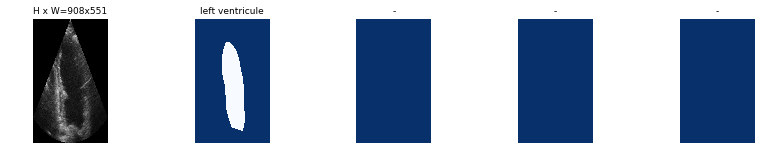

185
image mean: 41.101986
(843, 512, 1)
mask shape(843, 512, 1)


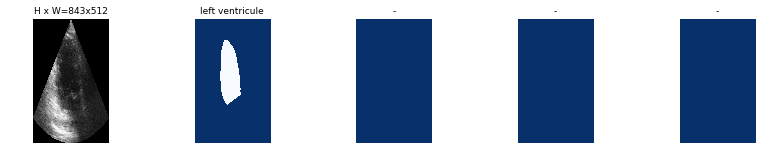

389
image mean: 44.794594
(1102, 669, 1)
mask shape(1102, 669, 1)


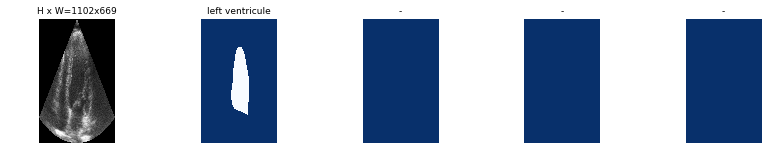

880
image mean: 53.17144
(1038, 630, 1)
mask shape(1038, 630, 1)


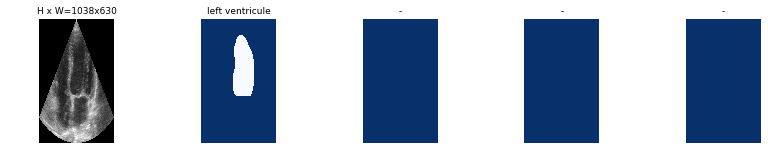

49.085747


In [2]:
dataset_dir = "/floyd/input"
dataset_train = CamusDataset()
dataset_train.load_camus_images(dataset_dir,"train")
dataset_train.prepare()

# Validation dataset
dataset_val = CamusDataset()
dataset_val.load_camus_images(dataset_dir, "validation")
dataset_val.prepare()

dataset_test = CamusDataset()
dataset_test.load_camus_images(dataset_dir, "test")#Test dataset
dataset_test.prepare()

print("Image Count: {}".format(len(dataset_train.image_ids)))
print("Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))

augmentation = iaa.SomeOf((0, 2), [
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.OneOf([iaa.Affine(rotate=90),
            iaa.Affine(rotate=180),
            iaa.Affine(rotate=270)]),
    iaa.Multiply((0.8, 1.5)),
    iaa.GaussianBlur(sigma=(0.0, 5.0))
])
print(DEBUG)
if DEBUG:
    image_id=0
    print(dataset_train.image_ids.shape)
    print(dataset_train.image_ids[0])
    print(dataset_train.image_ids[-1])
    im=dataset_train.load_image(image_id)
    print("image shape:"+str(im.shape))
    m,c = dataset_train.load_mask(image_id)
    print("mask shape:"+str(m.shape))
image_ids = np.random.choice(dataset_train.image_ids, 4)
print(dataset_train.image_ids)
for image_id in image_ids:
    print(image_id)
    image = dataset_train.load_image(image_id)
    print("image mean: "+str(np.mean(image)))
    mask, class_ids = dataset_train.load_mask(image_id)
    print(image.shape)
    print("mask shape"+str(mask.shape))
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
          
DEBUG=False
mean=[]
count=0
for image in dataset_train.image_ids:
    mean.append(np.mean(dataset_train.load_image(image)))
    count+=1
for im in dataset_val.image_ids:
    mean.append(np.mean(dataset_val.load_image(im)))
    count+=1
print(np.mean(mean))#mean 49.085747 
    

**Choose weights**

Ground truth Mask and BBOX

In [3]:

infConf=CamusInferenceConfig()
infConf.display()

model = modellib.MaskRCNN(mode="inference", 
                          config=infConf,
                          model_dir=MODEL_DIR)



# def detect (model, image_path=None):
init_with = "custom"  # imagenet, coco, or last or custom

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_WEIGHTS_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)
elif init_with == "custom":
    model_path = "/floyd/home/logs/mask_rcnn_camusgrayscale_0053.h5"
#     model_path = "/floyd/home/logs/mask_rcnn_camusgrayscale_0072.h5"
    

    # Load trained weights
    print("Loading weights from ", model_path)
    model.load_weights(model_path, by_name=True)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        1
DETECTION_MIN_CONFIDENCE       0.01
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            1
IMAGE_MAX_DIM                  448
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  448
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [448 448   1]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [4]:
############################################################
#  Detection
############################################################
from mrcnn.model import log
from medpy.metric.binary import dc,hd,assd
def detect (model, image_path=None):
    
    # Run model detection 
    print("Running on {}".format(args.image))
    # Read image
    image=sitk.GetArrayFromImage(sitk.ReadImage(mask_id, sitk.sitkFloat32))
    # Detect objects
    r = model.detect([image], verbose=1)[0]
        # Save output
        #file_name = "splash_{:%Y%m%dT%H%M%S}.png".format(datetime.datetime.now())
        #skimage.io.imsave(file_name, splash)
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax



In [3]:
from medpy.metric.binary import dc
dataset=dataset_test

def assd_all (gt_mask,r):
	res=0.0
	#metrics=np.zeros(3)
	for i in range(0,r['masks'].shape[2]):
		res+=metric.binary.assd(gt_mask[:,:,r['class_ids'][i]-1],r['masks'][:,:,i],voxelspacing=[voxel_spacing[1], voxel_spacing[0]])
	if(r['masks'].shape[2]<3):
		print("Warning, detected classes : ",r['class_ids']) 
	return res/(float)(r['masks'].shape[2])

def hd_all (gt_mask,r):
	res=0.0
	for i in range(0,r['masks'].shape[2]):
		res+=metric.binary.hd(gt_mask[:,:,r['class_ids'][i]-1],r['masks'][:,:,i],voxelspacing=[voxel_spacing[1], voxel_spacing[0]])
	return res/(float)(r['masks'].shape[2])

def dice_all(gt_mask,r):
	res=0.0
	for i in range (0,r['masks'].shape[2]):
		res+=metric.binary.dc(gt_mask[:,:,r['class_ids'][i]-1],r['masks'][:,:,i])
	return res/(float)(r['masks'].shape[2])
image_ids = dataset.image_ids#np.random.choice(dataset_val.image_ids, 200)
diceBatch=[]
assdBatch=[]
hdBatch=[]
empty_mask=0
problemIDs=[]#absence du masque
for image_id in image_ids:
    # Load image and ground truth data
    image= dataset.load_image(image_id)
    gt_mask,cl_ids=dataset.load_mask(image_id)
    results = model.detect([image], verbose=0)
    r = results[0]
    res=0.0
#     #print(image_id)
#     print(r["masks"].shape)
#     print(gt_mask.shape)
    try:
        dOneD,dTwoD,dThreeD,resD=dice_all(gt_mask,r)
        dOneH,dTwoH,dThreeH,resH=hd_all(gt_mask,r)
        dOneA,dTwoA,dThreeA,resA=assd_all(gt_mask,r)
        diceBatch.append(resD)
        hdBatch.append(resH)
        assdBatch.append(resA)
    except:
        empty_mask+=1
        problemIDs.append(image_id)
        continue
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(diceBatch)

fig2, ax2 = plt.subplots()
ax2.set_title('HD Plot')
ax2.boxplot(hdBatch)

fig3, ax2 = plt.subplots()
ax2.set_title('ASSD Plot')
ax2.boxplot(assdBatch)

print("Mean Dice: ", np.mean(diceBatch)," Std: ",np.std(diceBatch))
print("Mean ASSD: ", np.mean(assdBatch)," Std: ",np.std(assdBatch))
print("Mean HD: ", np.mean(hdBatch)," Std: ",np.std(hdBatch))
print("empty_mask problems:"+str(empty_mask))
print("problematic masks ids: "+str(problemIDs))
#print(diceBatch)

NameError: name 'model' is not defined

### UNIT DETECTION VISUALISATION WITH RESIZING TO ORIGINAL CV2

Processing 1 images
image                    shape: (448, 448, 1)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 448, 448, 1)      min: -100.00000  max:  155.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  448.00000  int64
anchors                  shape: (1, 50127, 4)         min:   -0.80993  max:    1.66675  float32


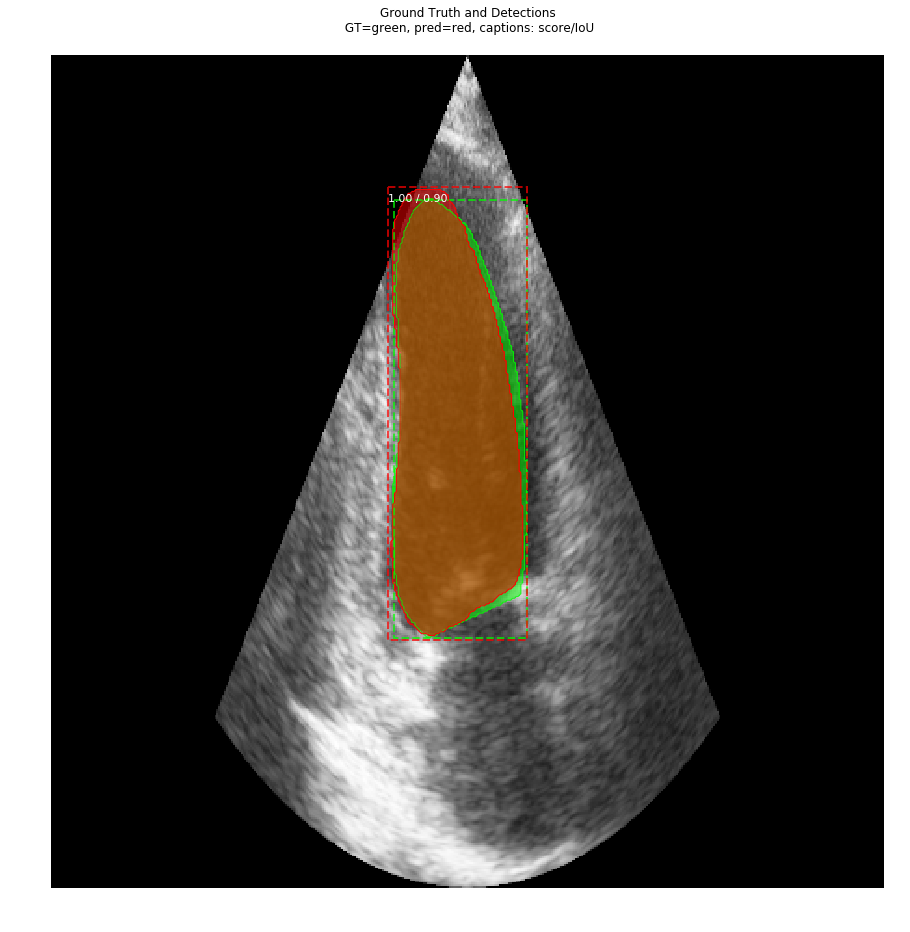

(1038, 630)
dice before resizing:0.9482029598308668
dice after resizing:0.9319863053594196
hd after resizing:7.085673715321642
assd after resizing:2.0105967535180427
padding[(0, 0), (88, 88), (0, 0)]
padding left88
original_image           shape: (448, 448, 1)         min:    0.00000  max:  255.00000  float32
image_meta               shape: (14,)                 min:    0.00000  max: 1038.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   77.00000  max:  313.00000  int32
gt_mask                  shape: (448, 448, 1)         min:    0.00000  max:    1.00000  float32


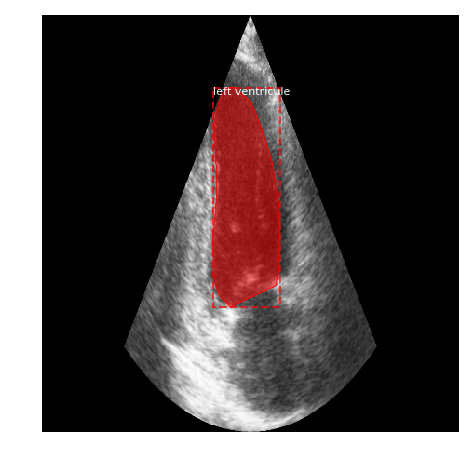

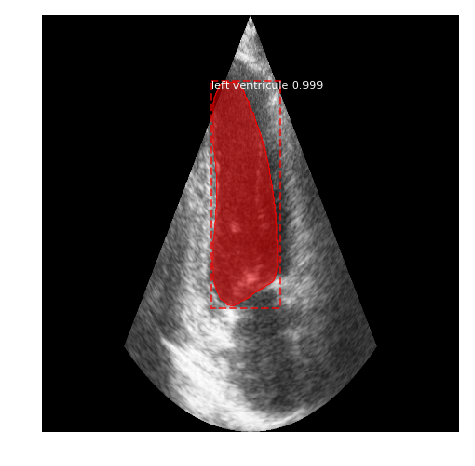

r['masks'] shape:(448, 448, 1)
rois: (1, 4)
original mask shape(1038, 630)


NameError: name 'scale' is not defined

In [8]:
import PIL
import cv2
import matplotlib.pyplot as plt
from medpy.metric.binary import dc,hd,assd
from mrcnn.utils import unmold_mask,resize
verbose=0
voxel_spacing = [0.308, 0.154]

image_id = np.random.choice(dataset_val.image_ids)
# image_id=13
or_image, image_meta, gt_class_id, gt_bbox, gt_mask, padding, scaleResize =\
    modellib.load_image_gt(dataset_val, infConf, 
                           image_id, use_mini_mask=False)
results = model.detect([or_image], verbose)
r = results[0]

mask,class_ids=dataset_val.load_mask(image_id)

width=mask.shape[0]
height=mask.shape[1]
dim = (height,width)
prediced=np.float32(r['masks'])
# scale=max(width,height)/256
if(padding[1][0]!=0):#padding left NON-ZERO
    prediced=prediced[:,padding[1][0]:-padding[1][1],:]
elif(padding[0][0]!=0):#padding top or bottom is not equal 0 NEVER OCCURS in our dataset
    prediced=prediced[padding[0][0]:-padding[0][1],padding[1][0]:-padding[1][1],:]
resized = cv2.resize(prediced, dim, interpolation = cv2.INTER_LANCZOS4)
mask=mask.squeeze(axis=2)

print(resized.shape)
print("dice before resizing:"+str(dc(gt_mask,r['masks'])))
print("dice after resizing:"+str(dc(mask,resized)))
print("hd after resizing:"+str(hd(mask,resized, connectivity=2,voxelspacing=[voxel_spacing[1], voxel_spacing[0]]) ))
print("assd after resizing:"+str(assd(mask,resized, connectivity=2,voxelspacing=[voxel_spacing[1], voxel_spacing[0]]) ))

if verbose:
    
    print("padding"+str(padding))
    print("padding left"+str(padding[1][0]))
    log("original_image", or_image)
    log("image_meta", image_meta)
    log("gt_class_id", gt_class_id)
    log("gt_bbox", gt_bbox)
    log("gt_mask", gt_mask)


    visualize.display_instances(or_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset_train.class_names, figsize=(8, 8))

    #segmentation

    visualize.display_instances(or_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(8, 8))
    print("r['masks'] shape:"+str(r['masks'].shape))
    print("rois: "+str(r['rois'].shape))
    print("original mask shape"+str(mask.shape))
    print("scale: "+str(scale))
    print("predicted shape:"+str(prediced.shape))
    plt.subplot(211)
    plt.imshow(mask)
    plt.show()
    mask=np.expand_dims(mask,axis=2)
    print("resized predicted mask: ")
    plt.subplot(212)
    plt.imshow(resized)
    plt.show()
    resized=np.expand_dims(resized,axis=2) 


In [10]:
image_id=np.rand_int(dataset_val)
original_image=dataset_val.load_image(image_id)
results = model.detect([original_image], verbose=0)
r = results[0]
gt_mask, class_ids = dataset_val.load_mask(image_id)


visualize.display_differences(or_image,
                    gt_bbox, gt_class_id, gt_mask,
                    pred_box=r['rois'], pred_class_id=r["class_ids"], pred_score=r["scores"], pred_mask=r["masks"],
                    class_names=dataset_val.class_names, 
                    title="", ax=None,
                    show_mask=True, show_box=True,
                    iou_threshold=0.5, score_threshold=0.5)

IndentationError: unexpected indent (<ipython-input-10-92a9f405dfdc>, line 8)

### Segmentation Mask and BBOX

Evaluation : Mean Average Precision mAP

In [ ]:
DEBUG=False
if DEBUG:
   print(r['masks'].shape) 

In [ ]:
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, infConf,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, infConf), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

### Method with unmold detctions

Mean Dice:  0.9161088149465758  Std:  0.037789008163027944
Mean HD:  6.017063956322894  Std:  2.637544006366506
Mean ASD:  1.8568566479134643  Std:  0.818946268388365


{'whiskers': [<matplotlib.lines.Line2D at 0x7fa444208cc0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa444212390>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa444208b70>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa444212a20>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa444212d68>],
 'means': []}

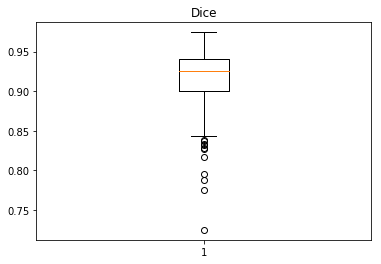

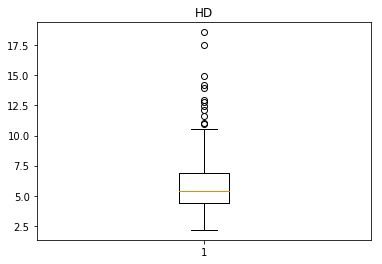

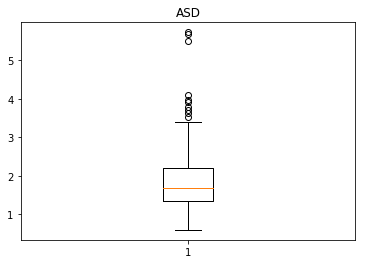

In [9]:
import tensorflow as tf
from medpy import metric
with tf.device("/gpu:0"):
    voxel_spacing = [0.308, 0.154]
    def dice(y_trueI, y_predI):
        try:

            """ Binary dice indice adapted to keras tensors """
            y_true=y_trueI.astype(float)
            y_pred=y_predI.astype(float)
            flat_y_true = k.flatten(y_true)
            flat_y_pred = k.flatten(y_pred)
            intersect = k.sum(flat_y_true * flat_y_pred)

            s_true = k.sum(flat_y_true)
            s_pred = k.sum(flat_y_pred)
            if DEBUG:
                print(flat_y_true)
                print(flat_y_pred)
                print(type(intersect))
                print(s_pred)
            res=tf.Session().run((2. * intersect + 1.) / (s_true + s_pred + 1.))
            return res
        except:
            print ("NO MASK !")
            return 0.0
    def hd (seg,gt):
        hdMask = metric.binary.hd(seg, gt, connectivity=2,voxelspacing=[voxel_spacing[1], voxel_spacing[0]])                   
        return hdMask
       
    def asd (seg,gt):

        asdMask = metric.binary.assd(seg, gt, connectivity=2,voxelspacing=[voxel_spacing[1], voxel_spacing[0]])                   
        return asdMask
         
    #***************************************************************************************************#
    
    #image_ids = np.random.choice(dataset_val.image_ids, 1)
    image_ids = dataset_test.image_ids
    APs = []
    DICEs = []
    HDs = []
    ASDs = []
    for image_id in image_ids:
   # Load image and ground truth data
        original_image=dataset_test.load_image(image_id)
#     imageBatch.append()
        results = model.detect([original_image], verbose=0)
        r = results[0]
        gt_mask, class_ids = dataset_test.load_mask(image_id)
        # Compute AP
        #AP, precisions, recalls, overlaps =\
            #utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
             #                r["rois"], r["class_ids"], r["scores"], r['masks'])
        #APs.append(AP)
    # Compute dice 
        DICEs.append(dc(gt_mask,r['masks']))
    # Compute hd
        HDs.append(hd(r['masks'].squeeze(axis=2), gt_mask.squeeze(axis=2)))
    # Compute asd
        ASDs.append(asd(r['masks'].squeeze(axis=2), gt_mask.squeeze(axis=2)))
        #print(metric.binary.dc(r['masks'], gt_mask))  
        
        #print(r['masks'].squeeze(axis=2).shape)
        #print(metric.binary.hd(r['masks'], gt_mask,connectivity=2,voxelspacing=[voxel_spacing[1], voxel_spacing[0], 1])) 
        #print(metric.binary.hd(r['masks'].squeeze(axis=2), gt_mask.squeeze(axis=2),connectivity=2,voxelspacing=[voxel_spacing[1], voxel_spacing[0]])) 
        
# print("mAP: ", np.mean(APs)," Std: ",np.std(APs))
# fig1, ax1 = plt.subplots()
# ax1.set_title('AP')
# ax1.boxplot(APs)
print("Mean Dice: ", np.mean(DICEs)," Std: ",np.std(DICEs))
fig2, ax2 = plt.subplots()
ax2.set_title('Dice')
ax2.boxplot(DICEs)
HDs=np.asarray(HDs)
ASDs=np.asarray(ASDs)
print("Mean HD: ", HDs[HDs>0].mean()," Std: ",np.std(HDs))
fig3, ax3 = plt.subplots()
ax3.set_title('HD')
ax3.boxplot(HDs)
print("Mean ASD: ", np.mean(ASDs[ASDs>0])," Std: ",np.std(ASDs))
fig4, ax4 = plt.subplots()
ax4.set_title('ASD')
ax4.boxplot(ASDs)

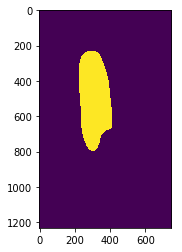

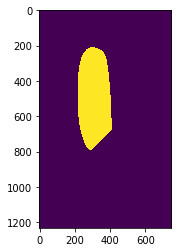

8.221118608973725


In [16]:
plt.imshow(r["masks"][:,:,0])
plt.show()
plt.imshow(gt_mask[:,:,0])
plt.show()
print(assd(r['masks'].squeeze(axis=2), gt_mask.squeeze(axis=2)))

In [ ]:
c=0
count=0
for dat in data:
    count+=1
    if dat<=0.01:
        c+=1
print(c/count)

### Method with OpenCV

In [ ]:
import tensorflow as tf
from medpy import metric

SAVE_MASKS_DIR=os.path.join(ROOT_DIR, "output")
print(SAVE_MASKS_DIR)
SAVE=False#True
with tf.device("/gpu:0"):
    voxel_spacing = [0.308, 0.154]
    def dice(y_trueI, y_predI):
        try:
            res=metric.binary.dc(y_trueI,y_predI)
            return res
        except:
            print ("NO MASK !")
            return 0.0

    def hd (seg,gt):
        hdMask = metric.binary.hd(seg, gt, connectivity=2,voxelspacing=[voxel_spacing[1], voxel_spacing[0]])                   
        return hdMask
    def asd (seg,gt):
        asdMask = metric.binary.assd(seg, gt, connectivity=2,voxelspacing=[voxel_spacing[1], voxel_spacing[0]])                   
        return asdMask
         
    #***************************************************************************************************#
    image_ids = dataset_test.image_ids
    APs = []
    DICEs = []
    HDs = []
    ASDs = []
    for image_id in image_ids:
   # Load image and ground truth data
        or_image, image_meta, gt_class_id, gt_bbox, gt_mask, padding, scaleResize =\
            modellib.load_image_gt(dataset_test, infConf, 
                                   image_id, use_mini_mask=False)
        results = model.detect([or_image], verbose=0)
        r = results[0]

        mask,class_ids=dataset_test.load_mask(image_id)

        width=mask.shape[0]
        height=mask.shape[1]
        dim = (height,width)
        prediced=np.float32(r['masks'])
        # scale=max(width,height)/256
        if(padding[1][0]!=0):#padding left NON-ZERO
            prediced=prediced[:,padding[1][0]:-padding[1][1],:]
        elif(padding[0][0]!=0):#padding top or bottom is not equal 0 NEVER OCCURS in our dataset
            prediced=prediced[padding[0][0]:-padding[0][1],padding[1][0]:-padding[1][1],:]
        resized = cv2.resize(prediced, dim, interpolation = cv2.INTER_LANCZOS4)
        mask=mask.squeeze(axis=2)
        if SAVE:#sauvgarde du masque
            resized=np.expand_dims(resized,axis=2)
            filename=SAVE_MASKS_DIR+"/mask_TEST_"+str(image_id)+".mhd"
            im = sitk.GetImageFromArray(resized, isVector=False)
            sitk.WriteImage(im, filename, False)
            resized=np.squeeze(resized,axis=2)
#         print(mask.shape)
#         print(resized.shape)
    # Compute dice 
        DICEs.append(dc(resized, mask))
    # Compute hd
        HDs.append(hd(resized, mask))
    # Compute asd
        ASDs.append(asd(resized, mask))
print("Mean Dice: ", np.mean(DICEs)," Std: ",np.std(DICEs))
fig2, ax2 = plt.subplots()
ax2.set_title('Dice')
ax2.boxplot(DICEs)
HDs=np.asarray(HDs)
ASDs=np.asarray(ASDs)
print("Mean HD: ", HDs[HDs>0].mean()," Std: ",np.std(HDs))
fig3, ax3 = plt.subplots()
ax3.set_title('HD')
ax3.boxplot(HDs)
print("Mean ASD: ", np.mean(ASDs[ASDs>0])," Std: ",np.std(ASDs))
fig4, ax4 = plt.subplots()
ax4.set_title('ASD')
ax4.boxplot(ASDs)

In [ ]:
from medpy import metric
import numpy as np

#image_ids = np.random.choice(dataset_val.image_ids, 200)
image_ids = dataset_val.image_ids
HDs_mask = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_test, infConf,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, infConf), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute HD
    HD_mask = metric.binary.hd(np.squeeze(r['masks'], axis=(2,)), np.squeeze(gt_mask, axis=(2,)), connectivity=2, voxelspacing=[voxel_spacing[1], voxel_spacing[0]])
    #print("HD mask : ", HD_mask)
    HDs_mask.append(HD_mask)
    
print("HD mask: ", np.mean(HDs_mask), "std: ", np.std(HDs_mask))
fig2, ax2 = plt.subplots()
ax2.set_title('HD Plot')
ax2.boxplot(HDs_mask)